In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.options.display.max_columns = 30

# Load data

In [2]:
data = pd.read_excel('data_sul_days_15y.xlsx')
data = data[['Data Escala de Tempo 1 CE Simp 4', 'Selecione Tipo de CE Simp 4']]
data.columns = ['date','load']
data = data[2:]
data.shape

(5995, 2)

In [3]:
data.iloc[np.r_[0:2, -2:0]]

,date,load
2,2005-01-01 00:00:00,134.95552
3,2005-02-01 00:00:00,140.24240
5995,05/30/2021 12:00:00 a.m.,209.56636
5996,05/31/2021 12:00:00 a.m.,276.47700


In [4]:
init_date = datetime(2005, 1, 1)
datelist = pd.date_range(init_date, periods=len(data)).tolist()

In [5]:
df = pd.DataFrame(data=data.load.values, index=datelist, columns=['Energy_Load'])
df.iloc[np.r_[0:2, -2:0]]

,Energy_Load
2005-01-01,134.95552
2005-01-02,140.24240
2021-05-30,209.56636
2021-05-31,276.47700


In [6]:
df[df.Energy_Load.isnull()]

,Energy_Load
2014-02-01,NaN


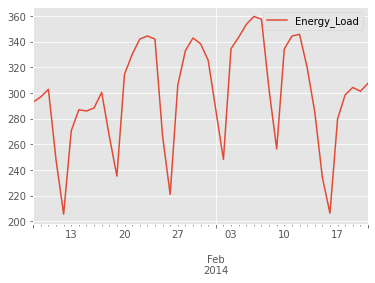

In [7]:
df.loc['2014-02-01','Energy_Load'] = (325.547854 + 248.323577)/2.
df.loc['2014-01-08':'2014-02-21'].plot()

In [8]:
df1 = df.resample('1M').sum()[['Energy_Load']]
df1['date'] = df1.index
df1['year'] = df1.date.dt.year
df1['month'] = df1.date.dt.month
df1.shape

(197, 4)

### Train-test split

In [9]:
train = df1.loc['2005-01-01':'2017-12-31']
print(train.shape)
train.iloc[np.r_[0:2, -2:0]]

(156, 4)


,Energy_Load,date,year,month
2005-01-31,5812.802010,2005-01-31,2005,1
2005-02-28,5400.981390,2005-02-28,2005,2
2017-11-30,7784.288831,2017-11-30,2017,11
2017-12-31,8463.833418,2017-12-31,2017,12


In [10]:
val = df1.loc['2017-01-01':'2018-12-31']
print(val.shape)
val.iloc[np.r_[0:6, -2:0]]

(24, 4)


,Energy_Load,date,year,month
2017-01-31,8854.093328,2017-01-31,2017,1
2017-02-28,8419.947337,2017-02-28,2017,2
2017-03-31,8681.010821,2017-03-31,2017,3
2017-04-30,7511.422554,2017-04-30,2017,4
2017-05-31,7633.607143,2017-05-31,2017,5
2017-06-30,7443.495293,2017-06-30,2017,6
2018-11-30,8140.952037,2018-11-30,2018,11
2018-12-31,8580.341897,2018-12-31,2018,12


In [11]:
test = df1.loc['2018-01-01':'2019-12-31']
print(test.shape)
test.iloc[np.r_[0:3, -2:0]]

(24, 4)


,Energy_Load,date,year,month
2018-01-31,8700.763152,2018-01-31,2018,1
2018-02-28,8124.509895,2018-02-28,2018,2
2018-03-31,8847.021982,2018-03-31,2018,3
2019-11-30,8317.804701,2019-11-30,2019,11
2019-12-31,8650.069685,2019-12-31,2019,12


## Data Pre-Processing

In [12]:
def preprocess(df_, windows, scale=False):

    _xt = []
    for i in range(windows, len(df_)):
        _y = df_.iloc[i]
        _m = _y.month
        _m = [float(i) for i in np.binary_repr(_m, width=4)]
        _xt_w = list(df_.iloc[i-windows:i].Energy_Load.values)

        _x = _m + _xt_w + [_y.Energy_Load]
        _xt.append(_x)
        
    _X = pd.DataFrame(_xt, columns=cols)
    
    if scale:
        _X.iloc[:,4:] = (_X.iloc[:,4:] - min_)/(max_ - min_)
    
    return _X

# Model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [14]:
def create_model(hidden_neurons=[4], lr=0.05, n_input=1):
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(hidden_neurons[0], input_dim=n_input, activation='relu'))
    for i in range(1,len(hidden_neurons)):
        model.add(Dense(hidden_neurons[i], input_dim=hidden_neurons[i-1], activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [15]:
def multistep(x_, y_, model_, encoding_month="binary"):

    yp = []
    
    if encoding_month=="binary":
        L=4
    elif encoding_month=="Nof1":
        L=12

    input_ = np.copy(x_)
    input_ = np.expand_dims(input_[0], axis=0) # just the first row // for val -> 12 steps // for test -> 5 steps

    for i in range(len(x_)):
        yt_ = model_.predict(input_)[0][0]
        yp.append(yt_)
        
        if i < len(x_)-1:
            # update input
            input_[0,:L] = x_[i+1,:L] # copy binary part
            input_[0,L:-1] = input_[0,(L+1):]
            input_[0,-1] = yt_

    return np.array(yp)

In [16]:
def calculate_metrics(y_true, y_predict, rescaling=True):
    
    if rescaling:
        y_true = y_true*(max_- min_) + min_
        y_predict = y_predict*(max_ - min_) + min_

    mae_error = mean_absolute_error(y_true, y_predict)
    mse_error = mean_squared_error(y_true, y_predict)
    rmse_error = np.sqrt(mse_error)
    mape = np.mean(np.abs((y_true.ravel() - y_predict.ravel()) / y_true.ravel())) * 100


    print(f'Erro MAE = {round(mae_error,3)}\nErro RMSE = {round(rmse_error,3)}')
    print("MAPE: ", np.round(mape,3), "%")

# Optimization

In [17]:
!pip install deap
!pip install bitstring

In [18]:
from deap import base, creator, tools, algorithms
import random

In [19]:
def aptidao(y_true, y_predict):
    
    y_true = y_true*(max_- min_) + min_
    y_predict = y_predict*(max_ - min_) + min_
    mape = np.mean(np.abs((y_true.ravel() - y_predict.ravel()) / y_true.ravel())) * 100
    print("MAPE: ", mape)

    return mape

In [20]:
def train_evaluate(ga_individual_solution): 

    global cols
    global max_, min_

    num_units, epochs, wdw = ga_individual_solution

    print('\nNum of Units: {} - epochs: {} - windows: {}'.format(num_units, epochs, wdw))

    # data pre-processing
    lt_w = ['x[t-{}]'.format(str(i)) for i in reversed(range(1, wdw+1))]
    cols = ['m[0]', 'm[1]', 'm[2]', 'm[3]'] + lt_w + ['x[t]']

    X = preprocess(train, windows=wdw)
    max_ = np.max(X.iloc[:,4:].values)
    min_ = np.min(X.iloc[:,4:].values)

    X.iloc[:,4:] = (X.iloc[:,4:] - min_)/(max_ - min_)

    Xval = preprocess(val, windows=wdw, scale=True)

    x_train = X.values[:,:-1]
    y_train = X.values[:,-1]

    x_val = Xval.values[:,:-1]
    y_val = Xval.values[:,-1] # y[t+1]
    
    # Train neural network and predict on validation set
    model = create_model(hidden_neurons = [num_units], n_input = x_train.shape[1], lr = 0.001)
    model.fit(x_train, y_train, epochs=epochs, verbose=0)

    y_pred_val_ms = multistep(x_val, y_val, model)
    
    # Calculate the MAPE score as fitness score for GA
    return aptidao(y_val, y_pred_val_ms),

In [23]:
population_size = 50
num_generations = 12

creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list,  fitness=creator.FitnessMax) 

toolbox = base.Toolbox()

toolbox.register("attr_int1", random.randint, 5, 150) # units
toolbox.register("attr_int2", random.randint, 5, 200) # epochs
toolbox.register("attr_int3", random.randint, 1, 12)  # windows

# Individuals and population
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_int1, toolbox.attr_int2, toolbox.attr_int3), 1) 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operations
toolbox.register("evaluate", train_evaluate)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, low=[5,5,1], up=[150,200,12], indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


population = toolbox.population(n=population_size)
r = algorithms.eaSimple(population, toolbox, cxpb=0.4, mutpb = 0.1, ngen=num_generations, verbose = False)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Num of Units: 87 - epochs: 66 - windows: 4
MAPE:  3.092439184182879

Num of Units: 107 - epochs: 62 - windows: 3
MAPE:  2.3678214999694336

Num of Units: 82 - epochs: 194 - windows: 5
MAPE:  3.495604654358026

Num of Units: 39 - epochs: 101 - windows: 11
MAPE:  1.837125304958525

Num of Units: 74 - epochs: 40 - windows: 7
MAPE:  2.3899386011939088

Num of Units: 15 - epochs: 17 - windows: 9
MAPE:  11.773653571152249

Num of Units: 142 - epochs: 189 - windows: 8
MAPE:  2.4220874551370972

Num of Units: 43 - epochs: 127 - windows: 6
MAPE:  2.055401745129442

Num of Units: 120 - epochs: 96 - windows: 3
MAPE:  1.836546564786335

Num of Units: 85 - epochs: 168 - windows: 11
MAPE:  2.160964667992799

Num of Units: 69 - epochs: 149 - windows: 9
MAPE:  2.2725923604643468

Num of Units: 150 - epochs: 142 - windows: 9
MAPE:  2.0401430296654697

Num of Units: 10 - epochs: 199 - windows: 11
MAPE:  3.1235519734218857

Num of Units: 102 - epochs: 104 - windows: 4
MAPE:  1.6807746271565702

Num of U

In [25]:
# Print top N solutions
best_individuals = tools.selBest(population, k=3)

for bi in best_individuals:
    print(bi)
    train_evaluate(bi)

[120, 75, 4]

Num of Units: 120 - epochs: 75 - windows: 4
MAPE:  1.6037282346252193
[120, 75, 4]

Num of Units: 120 - epochs: 75 - windows: 4
MAPE:  1.6037282346252193
[120, 75, 4]

Num of Units: 120 - epochs: 75 - windows: 4
MAPE:  1.6037282346252193


# Train with optimized parameters

In [26]:
# hn, ep, wdw = best_individuals[0]

hn = 56
ep = 110
wdw = 5

In [27]:
lt_w = ['x[t-{}]'.format(str(i)) for i in reversed(range(1, wdw+1))]
cols = ['m[0]', 'm[1]', 'm[2]', 'm[3]'] + lt_w + ['x[t]']

X = preprocess(train, windows=wdw)
max_ = np.max(X.iloc[:,4:].values)
min_ = np.min(X.iloc[:,4:].values)

X.iloc[:,4:] = (X.iloc[:,4:] - min_)/(max_ - min_)

Xval = preprocess(val, windows=wdw, scale=True)
Xtest = preprocess(test, windows=wdw, scale=True)

x_train = X.values[:,:-1]
y_train = X.values[:,-1]

x_val = Xval.values[:,:-1]
y_val = Xval.values[:,-1]

x_test = Xtest.values[:,:-1]
y_test = Xtest.values[:,-1]

In [28]:
model1 = create_model(hidden_neurons = [hn], n_input = x_train.shape[1], lr = 0.001)

In [29]:
hs1 = model1.fit(x=x_train, y=y_train, epochs=ep,
                 validation_data=(x_val, y_val), verbose=0)

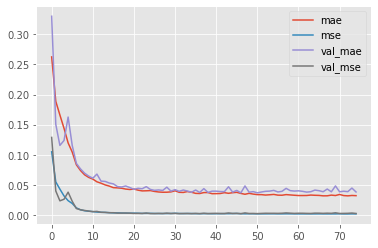

In [30]:
plt.plot(hs1.history['loss'], label="mae")
plt.plot(hs1.history['mean_squared_error'], label="mse")
plt.plot(hs1.history['val_loss'], label="val_mae")
plt.plot(hs1.history['val_mean_squared_error'], label="val_mse")
plt.legend()
plt.show()

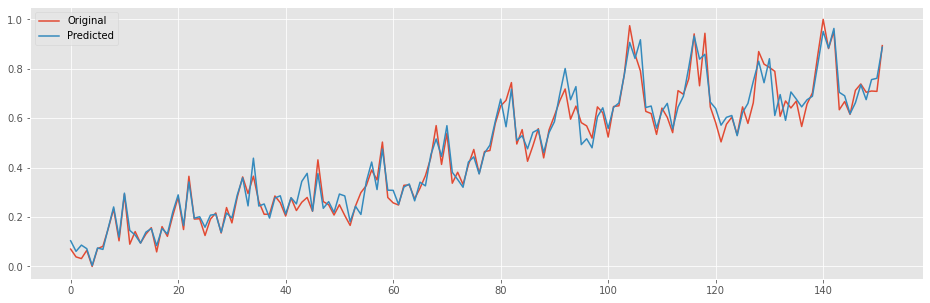

In [31]:
y_train_hat = model1.predict(x_train)

plt.figure(figsize=[16,5])
plt.plot(y_train)
plt.plot(y_train_hat)
plt.legend(['Original','Predicted'])

In [32]:
y_val_hat = model1.predict(x_val)
y_val_ms = multistep(x_val, y_val, model1)
calculate_metrics(y_val, y_val_ms)

Erro MAE = 128.061
Erro RMSE = 182.325
MAPE:  1.604 %


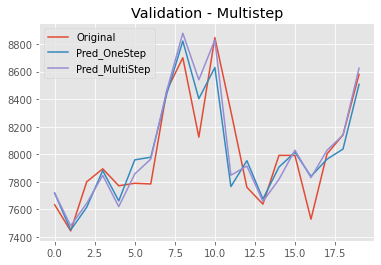

In [33]:
plt.plot(y_val*(max_- min_) + min_)
plt.plot(y_val_hat.ravel()*(max_- min_) + min_)
plt.plot(y_val_ms*(max_- min_) + min_)
plt.legend(['Original','Pred_OneStep', 'Pred_MultiStep'])
plt.title('Validation - Multistep')
plt.show()

# Testing

In [34]:
y_test_hat = model1.predict(x_test)
y_test_ms = multistep(x_test, y_test, model1)

In [35]:
calculate_metrics(y_test, y_test_ms)

Erro MAE = 206.3
Erro RMSE = 252.139
MAPE:  2.522 %


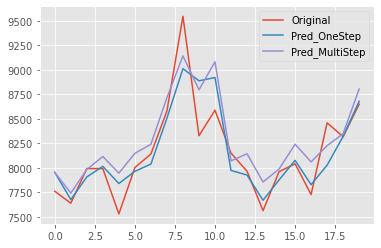

In [36]:
plt.plot(y_test*(max_- min_) + min_)
plt.plot(y_test_hat.ravel()*(max_- min_) + min_)
plt.plot(y_test_ms*(max_- min_) + min_)
plt.legend(['Original','Pred_OneStep', 'Pred_MultiStep'])
plt.show()

# Forecasting 2020

In [37]:
pred_set = df1.loc['2019-01-01':'2021-12-31']
print(pred_set.shape)
pred_set.iloc[np.r_[0:3, -2:0]]

(29, 4)


,Energy_Load,date,year,month
2019-01-31,9548.465809,2019-01-31,2019,1
2019-02-28,8327.847226,2019-02-28,2019,2
2019-03-31,8587.788770,2019-03-31,2019,3
2021-04-30,8606.498493,2021-04-30,2021,4
2021-05-31,8463.734421,2021-05-31,2021,5


In [45]:
pred_set = pred_set[(12-wdw):]

In [46]:
Xforec = preprocess(pred_set, windows=wdw, scale=True)
print(Xforec.shape)
Xforec.head()

(17, 9)


,m[0],m[1],m[2],m[3],x[t-4],x[t-3],x[t-2],x[t-1],x[t]
0,0.0,0.0,0.0,1.0,0.692768,0.892445,0.853890,0.944414,1.141580
1,0.0,0.0,1.0,0.0,0.892445,0.853890,0.944414,1.141580,1.011490
2,0.0,0.0,1.0,1.0,0.853890,0.944414,1.141580,1.011490,1.083031
3,0.0,1.0,0.0,0.0,0.944414,1.141580,1.011490,1.083031,0.601477
4,0.0,1.0,0.0,1.0,1.141580,1.011490,1.083031,0.601477,0.634072


In [47]:
x_forec = Xforec.values[:,:-1]
y_forec = Xforec.values[:,-1]

In [48]:
y_forec_ms = multistep(x_forec, y_forec, model1)

In [49]:
# colsx = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
colsx = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

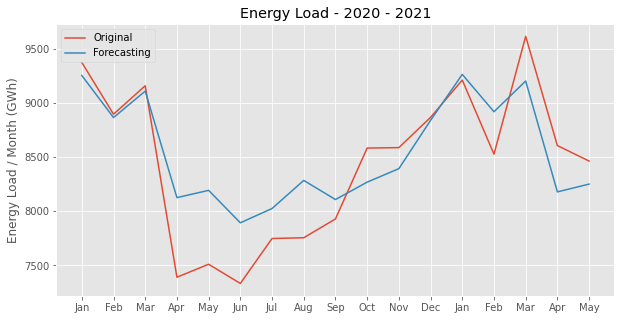

In [50]:
plt.figure(figsize=[10,5])
plt.title("Energy Load - 2020 - 2021")
plt.plot(y_forec*(max_- min_) + min_)
plt.plot(y_forec_ms*(max_- min_) + min_)
plt.legend(['Original', 'Forecasting'])
plt.ylabel('Energy Load / Month (GWh)')
plt.xticks([i for i in range(len(colsx))], colsx)
plt.show()

In [51]:
y_forec_sc = y_forec*(max_- min_) + min_
y_forec_ms_sc = y_forec_ms*(max_- min_) + min_

dif_p = np.abs((y_forec_sc.ravel() - y_forec_ms_sc.ravel()) / y_forec_sc.ravel()) * 100

In [52]:
df_2020 = pd.DataFrame(dif_p).T
df_2020.columns = colsx
df_2020

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May
0,1.280973,0.346636,0.540603,9.941277,9.083384,7.633739,3.575628,6.824344,2.258819,3.664019,2.262655,0.306949,0.568612,4.593628,4.286084,4.966637,2.514128


In [53]:
df_2020.iloc[:,:12].mean(axis=1)

0    3.976586
dtype: float64

# Forecasting 2021

In [54]:
pred_set2 = df1.loc['2020-01-01':'2021-12-31']
print(pred_set2.shape)
pred_set2.iloc[np.r_[0:3, -2:0]]

(17, 4)


,Energy_Load,date,year,month
2020-01-31,9373.754913,2020-01-31,2020,1
2020-02-29,8896.265363,2020-02-29,2020,2
2020-03-31,9158.852864,2020-03-31,2020,3
2021-04-30,8606.498493,2021-04-30,2021,4
2021-05-31,8463.734421,2021-05-31,2021,5


In [56]:
pred_set2 = pred_set2[(12-wdw):]

In [57]:
Xforec2 = preprocess(pred_set2, windows=wdw, scale=True)
print(Xforec2.shape)
Xforec2.head()

(5, 9)


,m[0],m[1],m[2],m[3],x[t-4],x[t-3],x[t-2],x[t-1],x[t]
0,0.0,0.0,0.0,1.0,0.748008,0.926335,0.927404,1.003497,1.097332
1,0.0,0.0,1.0,0.0,0.926335,0.927404,1.003497,1.097332,0.910962
2,0.0,0.0,1.0,1.0,0.927404,1.003497,1.097332,0.910962,1.207292
3,0.0,1.0,0.0,0.0,1.003497,1.097332,0.910962,1.207292,0.932543
4,0.0,1.0,0.0,1.0,1.097332,0.910962,1.207292,0.932543,0.893648


In [58]:
x_forec2 = Xforec2.values[:,:-1]
y_forec2 = Xforec2.values[:,-1]

In [59]:
y_forec2_ms = multistep(x_forec2, y_forec2, model1)

In [60]:
colsx2 = ['Jan','Feb','Mar','Apr','May']

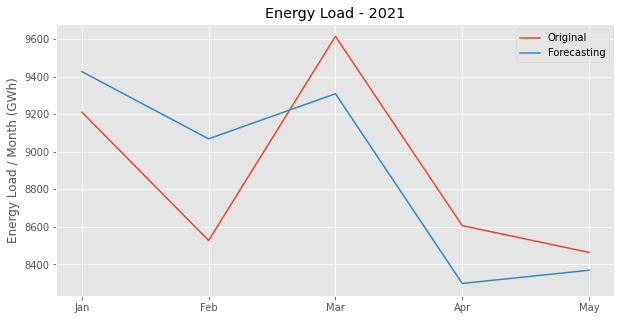

In [61]:
plt.figure(figsize=[10,5])
plt.title("Energy Load - 2021")
plt.plot(y_forec2*(max_- min_) + min_)
plt.plot(y_forec2_ms*(max_- min_) + min_)
plt.legend(['Original', 'Forecasting'])
plt.ylabel('Energy Load / Month (GWh)')
plt.xticks([i for i in range(len(colsx2))], colsx2)
plt.show()

In [62]:
y_forec2_sc = y_forec2*(max_- min_) + min_
y_forec2_ms_sc = y_forec2_ms*(max_- min_) + min_

In [63]:
dif_p2 = np.abs((y_forec2_sc.ravel() - y_forec2_ms_sc.ravel()) / y_forec2_sc.ravel()) * 100
df_2021 = pd.DataFrame(dif_p2).T
df_2021.columns = colsx2
df_2021

,Jan,Feb,Mar,Apr,May
0,2.342431,6.351267,3.180059,3.580478,1.123002


In [64]:
df_2021.mean(axis=1)

0    3.315447
dtype: float64